In [11]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items' )# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Bhavya1234@',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Mukul/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Bhavya1234@',
    database='ecommerce'
)

cur =  conn.cursor()


# List all unique cities where customers are located 

In [145]:
query = """SELECT DISTINCT customer_city FROM customers"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head(5)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017

In [54]:
query = """SELECT COUNT(order_id) FROM orders WHERE year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are" , data

('total orders placed in 2017 are', [(90202,)])

# Find the total sales per category.

In [97]:
query = """SELECT products.product_category category,
ROUND(sum(payments.payment_value),2) sales
FROM products JOIN order_items
ON products.product_id = order_items.product_id
JOIN payments
ON payments.order_id = order_items.order_id
GROUP BY category"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category" , "Sales"])
df

,Category,Sales
0,perfumery,4053909.28
1,Furniture Decoration,11441411.13
2,telephony,3895056.41
3,bed table bath,13700429.37
4,automotive,6818354.65
...,...,...
69,cds music dvds,9595.44
70,La Cuisine,23308.24
71,Fashion Children's Clothing,6285.36
72,PC Gamer,17395.44


# Calculate the percentage of orders that were paid in installments.

In [106]:
query = """SELECT (sum(case when payment_installments > 1 then 1
else 0 end)) / count(*)*100 
FROM payments"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is" , data

('the percentage of orders that were paid in installments is',
 [(Decimal('49.4176'),)])

# Count the number of customers from each state

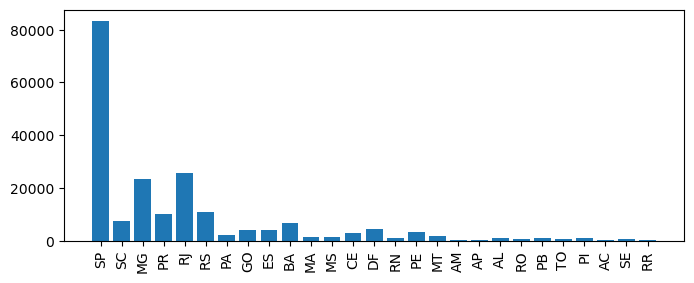

In [143]:
query = """SELECT customer_state , count(customer_id)
FROM customers
group by customer_state"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "total_customer" ])
plt.figure(figsize = (8,3))
plt.bar(df["state"] , df["total_customer"])

plt.xticks(rotation = 90)
plt.show()

#  Calculate the number of orders per month in 2018.

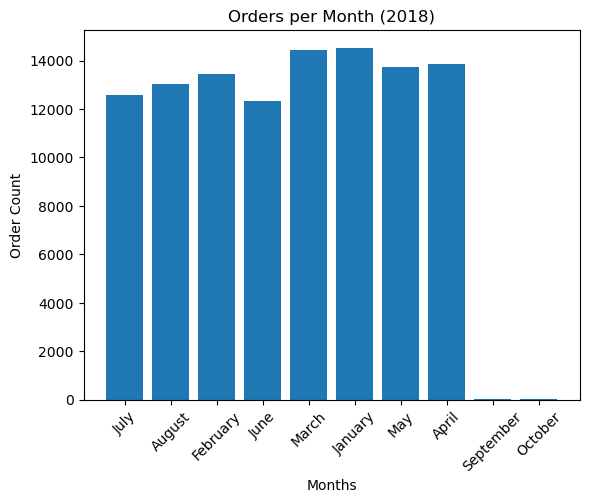

In [172]:
query = """SELECT monthname(order_purchase_timestamp) AS months, count(order_id) AS order_count
FROM orders 
WHERE year(order_purchase_timestamp) = 2018
GROUP BY months"""

cur.execute(query)

data = cur.fetchall()

# Convert data to DataFrame and assign column names
df = pd.DataFrame(data, columns=["months", "order_count"])

# Plot using corrected column names
plt.bar(df["months"], df["order_count"])
plt.xlabel("Months")
plt.ylabel("Order Count")
plt.title("Orders per Month (2018)")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()


# Find the average number of products per order, grouped by customer city.

In [203]:
query = """WITH count_per_order as
(SELECT orders.order_id, orders.customer_id, count(order_items.order_id) as oc
FROM orders
JOIN order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT customers.customer_city, round(avg(count_per_order.oc),2) average_orders
FROM customers JOIN count_per_order
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_city","average_products/order" ])
df.head(10)

,customer_city,average_products/order
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,curralinho,16.00
7,picarra,16.00
8,morro de sao paulo,16.00
9,teixeira soares,16.00


# Calculate the percentage of total revenue contributed by each product category.

In [21]:
query = """SELECT upper(products.product_category) category,
ROUND(sum(payments.payment_value)/(SELECT sum(payment_value) FROM payments)*100,2) sales_percentage
FROM products JOIN order_items
ON products.product_id = order_items.product_id
JOIN payments
ON payments.order_id = order_items.order_id
GROUP BY category ORDER BY sales_percentage desc
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category","Percentage distribution"])
df.head(7)

,Category,Percentage distribution
0,BED TABLE BATH,96.28
1,HEALTH BEAUTY,93.18
2,COMPUTER ACCESSORIES,89.13
3,FURNITURE DECORATION,80.40
4,WATCHES PRESENT,80.35
5,SPORT LEISURE,78.26
6,HOUSEWARES,61.55


# Identify the correlation between product price and the number of times a product has been purchased.

In [68]:
import numpy as np
import pandas as pd

# SQL query to fetch data
query = """
SELECT products.product_category,
       AVG(order_items.price) AS price, -- Include price in the query
       COUNT(order_items.product_id) AS order_count
FROM products
JOIN order_items 
ON products.product_id = order_items.product_id
GROUP BY products.product_category
"""

# Execute the query
cur.execute(query)
data = cur.fetchall()

# Correct DataFrame creation
columns = ['product_category', 'order_count', 'price']
df = pd.DataFrame(data, columns=columns)

# Extract arrays for correlation
arr1 = df["order_count"]
arr2 = df["price"]

# Calculate correlation coefficient
correlation_matrix = np.corrcoef(arr1, arr2)
print("the correlation between product price and the number of times a product has been purchased:\n", correlation_matrix)



the correlation between product price and the number of times a product has been purchased:
 [[ 1.         -0.10631552]
 [-0.10631552  1.        ]]


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [123]:
query = """SELECT *,
DENSE_RANK() OVER (ORDER BY revenue DESC) AS rank_position
FROM
(SELECT order_items.seller_id, sum(payments.payment_value) revenue
FROM order_items 
JOIN payments
ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id )
AS subquery
"""

cur.execute(query)

data = cur.fetchall()
columns = ['seller_id', 'revenue', 'rank_position']
df = pd.DataFrame(data, columns=columns)
print(df.head())


                          seller_id       revenue  rank_position
0  7c67e1448b00f6e969d365cea6b010ab  4.564502e+06              1
1  1025f0e2d44d7041d6cf58b6550e0bfa  2.773998e+06              2
2  4a3ca9315b744ce9f8e9374361493884  2.711207e+06              3
3  1f50f920176fa81dab994f9023523100  2.612281e+06              4
4  53243585a1d6dc2643021fd1853d8905  2.564128e+06              5


# Calculate the moving average of order values for each customer over their order history

In [143]:
query = """SELECT customer_id, order_purchase_timestamp, payment,
AVG(payment) OVER ( PARTITION BY customer_id
ORDER BY order_purchase_timestamp
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS moving_avg 
FROM
(SELECT orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
FROM payments JOIN orders 
ON payments.order_id = orders.order_id) as a;
"""

cur.execute(query)

data = cur.fetchall()
columns = ["customer_id", "purchase_timestamp","price","moving_average"]
df = pd.DataFrame(data, columns=columns)
print(df)

                             customer_id   purchase_timestamp   price  \
0       00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26  114.74   
1       00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26  114.74   
2       00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26  114.74   
3       00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26  114.74   
4       00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26  114.74   
...                                  ...                  ...     ...   
934969  ffffe8b65bbe3087b653a978c870db99  2017-09-29 14:07:03   18.37   
934970  ffffe8b65bbe3087b653a978c870db99  2017-09-29 14:07:03   18.37   
934971  ffffe8b65bbe3087b653a978c870db99  2017-09-29 14:07:03   18.37   
934972  ffffe8b65bbe3087b653a978c870db99  2017-09-29 14:07:03   18.37   
934973  ffffe8b65bbe3087b653a978c870db99  2017-09-29 14:07:03   18.37   

        moving_average  
0           114.739998  
1           114.739998  
2           114.739998  
3           114.739998 

# Calculate the cumulative sales per month for each year.

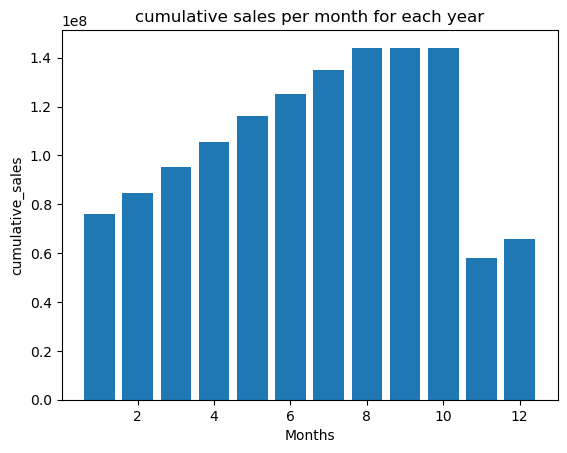

In [172]:
query = """SELECT years, months, total_payment, sum(total_payment)
OVER(ORDER BY  years,months) cumulative_sales
FROM
(SELECT YEAR(orders.order_purchase_timestamp) AS years,
    MONTH(orders.order_purchase_timestamp) AS months,
ROUND(SUM(payments.payment_value), 2) AS total_payment
FROM orders 
JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years, months 
ORDER BY years, months) AS subquery;

"""

cur.execute(query)

data = cur.fetchall()
columns = ["years", "months","total_payment","cumulative_sales"]
df = pd.DataFrame(data, columns=columns)
plt.bar(df["months"], df["cumulative_sales"])
plt.xlabel("Months")
plt.ylabel("cumulative_sales")
plt.title("cumulative sales per month for each year")
plt.show()

# Calculate the year-over-year growth rate of total sales.

In [207]:
query = """WITH a AS(SELECT YEAR(orders.order_purchase_timestamp) AS years,
ROUND(SUM(payments.payment_value), 2) AS total_payment
FROM orders 
JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years 
ORDER BY years)

SELECT years, ((total_payment - lag(total_payment,1) OVER(order by years) ) / 
lag(total_payment,1) over(order by years))*100
FROM a

"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ["years", "yoy% growth"])
print(df)

   years   yoy% growth
0   2016           NaN
1   2017  12112.703758
2   2018     20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [216]:
query = """ WITH a AS (
    SELECT customers.customer_id,
           MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers 
    JOIN orders
    ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
b AS (
    SELECT a.customer_id, 
           COUNT(DISTINCT orders.order_purchase_timestamp) AS order_count
    FROM a 
    JOIN orders
    ON orders.customer_id = a.customer_id
    AND orders.order_purchase_timestamp > a.first_order
    AND orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)
SELECT 100 * (COUNT(DISTINCT a.customer_id) / NULLIF(COUNT(DISTINCT b.customer_id), 0)) AS percentage
FROM a 
LEFT JOIN b
ON a.customer_id = b.customer_id;
"""

cur.execute(query)
data = cur.fetchall()
data

[(None,)]

#  Identify the top 3 customers who spent the most money in each year.

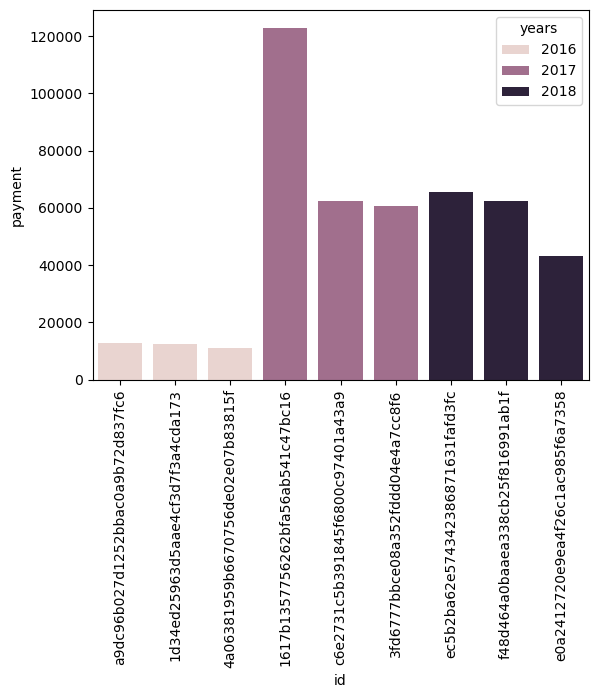

In [235]:
query = """ SELECT years, customer_id, payment, d_rank 
FROM (
    SELECT 
        year(orders.order_purchase_timestamp) AS years,
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (PARTITION BY YEAR(orders.order_purchase_timestamp)
                           ORDER BY SUM(payments.payment_value) DESC) AS d_rank
    FROM orders 
    JOIN payments
    ON payments.order_id = orders.order_id
    GROUP BY YEAR(orders.order_purchase_timestamp), orders.customer_id
) AS a 
WHERE d_rank <= 3;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id", "payment", "rank"])
sns.barplot(data = df, x = "id", y = "payment", hue = "years")
plt.xticks(rotation = 90)
plt.show()